**ACKNOWLEDGEMENT**: The original dataset <data.tsv> and general guideline was provided by Professor Jonathan Rose in the NLP class he taught in 2024.

**NOTE**: To streamline the whole process, the code from Section 3 (which prepares the data and saves them to tsv files for Section 4) is also included in this Python notebook.

# Data Preparation

**NOTE**: We will first need to upload `<data.tsv>` to the Files tab on the left toolbar of Colab before running the following code.

In [2]:
import os
import pandas as pd

df = pd.read_csv('data.tsv', sep='\t')

from sklearn.model_selection import train_test_split

# Create 4 datasets:
temp, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(temp, test_size=16/80, random_state=42)
overfit = train.sample(n=50, random_state=42) # the overfit dataset

# Save to TSV under the `data` directory:
if not os.path.exists('data'):
    os.makedirs('data')
train.to_csv(os.path.join('data', 'train.tsv'), sep='\t', index=False)
val.to_csv(os.path.join('data', 'validation.tsv'), sep='\t', index=False)
test.to_csv(os.path.join('data', 'test.tsv'), sep='\t', index=False)
overfit.to_csv(os.path.join('data', 'overfit.tsv'), sep='\t', index=False)

# Display number of samples in each set
print(f"Training dataset size: {len(train)}")
print(f"Validation dataset size: {len(val)}")
print(f"Test dataset size: {len(test)}")
print(f"Overfit dataset size: {len(overfit)}")

Training dataset size: 6400
Validation dataset size: 1600
Test dataset size: 2000
Overfit dataset size: 50


# Training a Baseline Model for Classification

## 1. Data Preprocessing

In [3]:
!pip install -U torchtext==0.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1+cu121
    Uninstalling torch-2.4.1+cu121:
      Successfully uninstalled torch-2.4.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.1+cu121 requires torch==2.4.1, but you have torch 1.11.0 which is incompatible.
torchvision 0.19.1+cu121 requires torch==2.4.1, but you have torch 1.11.0 which is incompatible.


The following section of code is obtained from `<A2_starter.py>`.

**ACKNOWLEDGEMENT**: The `TextDataset` class and `my_collate_function()` were provided in the NLP course materials.

In [4]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd

# TextDataset is Described in Section 3.3 of Assignment 2
# CUI: `vocab` is `glove`

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# my_collate_function prepares batches
# it also pads each batch with zeroes.
# CUI: It uses padding to make batches have the same length

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device),
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

## 2. Defining the Baseline Model

In [5]:
# Define an architecture for this classification task:

import torch.nn as nn
import torch.nn.functional as F

class BaselineModel(nn.Module):
    def __init__(self, vocab):
        super(BaselineModel, self).__init__()

        # Embedding layer:
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors, freeze=True)

        # Fully-connected layer:
        embedding_dim = vocab.vectors.shape[1]
        self.fc = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        # Note: x is an array of word indices, which is batch_size by max_seq_length

        # Step 1: Translate word indices to word embeddings:
        # print('x.shape:', x.shape)
        embeddings = self.embedding(x)

        # Step 2: Compute the average embedding:
        avg_embedding = embeddings.mean(dim=1)  # batch_size by embedding_dim

        # Step 3: Pass it through the fully-connected layer:
        output = self.fc(avg_embedding)

        # Note: We do NOT apply sigmoid here since BCEWithLogitsLoss includes it already

        return output

## 3. Testing the Baseline Model

We will move some code from the training loop to helper functions to make the full code more modular and readable.

In [7]:
# Pre-process the TSV files to generate our datasets:
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
train_dataset = TextDataset(glove, "train")
val_dataset = TextDataset(glove, "validation")
test_dataset = TextDataset(glove, "test")
overfit_dataset = TextDataset(glove, "overfit")

.vector_cache/glove.6B.zip: 862MB [02:41, 5.32MB/s]                           
100%|█████████▉| 399999/400000 [00:19<00:00, 20811.59it/s]


In [17]:
# Create dataloaders for batch training:
def create_dataloaders(args_batch_size = 4, device = 'cpu'):
  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=args_batch_size,
      shuffle=False,
      collate_fn=lambda batch: my_collate_function(batch, device))
  validation_dataloader = torch.utils.data.DataLoader(
      dataset=val_dataset,
      batch_size=args_batch_size,
      shuffle=False,
      collate_fn=lambda batch: my_collate_function(batch, device))
  test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=args_batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device)
  )
  overfit_loader = torch.utils.data.DataLoader(
    dataset=overfit_dataset,
    batch_size=args_batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device)
  )
  return train_dataloader, validation_dataloader, test_loader, overfit_loader

In [18]:
def plot_loss_curves(num_epochs, train_losses, val_losses):
  # Plotting
  plt.figure(figsize=(15, 5))

  # Plot training loss and test loss
  plt.subplot(1, 2, 1)
  plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
  plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss vs Epochs on overfit.tsv")
  plt.legend()

  plt.tight_layout()
  plt.show()

def plot_accuracy_curves(num_epochs, train_accuracies, val_accuracies):
  # Plotting
  plt.figure(figsize=(15, 5))

  # Plot training accuracy and test accuracy
  plt.subplot(1, 2, 2)
  plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
  plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs Epochs on overfit.tsv")
  plt.legend()

  plt.tight_layout()
  plt.show()

**NOTE**: The `train_losses` and `train_accuracies` in Section 4.4's code would refer to the variables for the overfit training dataset (which has only 50 examples).

In [19]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_overfit(args_batch_size = 4):
  torch.manual_seed(2)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print ("Using device:", device)

  # Hyperparameters:
  embedding_dim = 100 # We use embedding size = 100
  learning_rate = 0.001
  num_epochs = 50
  batch_size = args_batch_size

  # Initialize:
  model = BaselineModel(vocab=glove)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  train_loader, validation_loader, test_loader, overfit_loader = create_dataloaders(
      args_batch_size = args_batch_size, device = device
  )

  with tqdm(range(num_epochs), unit="epoch") as epochs_tqdm:
    epochs_tqdm.set_description("Training epochs:")
    for epoch in epochs_tqdm:
      model.train()

      total_loss = 0
      correct = 0
      total = 0

      for inputs, targets in overfit_loader:

        inputs = inputs.transpose(0, 1)

        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predicted = (torch.sigmoid(outputs) > 0.5).int()
        correct += (predicted.squeeze(-1) == targets).sum().item()

        total += targets.size(0)

      avg_loss = total_loss / len(overfit_loader)
      accuracy = correct / total

      train_losses.append(avg_loss)
      train_accuracies.append(accuracy)

      # Evaluate on the val set after each epoch:
      model.eval()
      total_val_loss = 0
      correct_val = 0
      total_val = 0

      with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.transpose(0, 1)

            outputs = model.forward(inputs)
            val_loss = criterion(outputs, targets.unsqueeze(1).float())

            total_val_loss += val_loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).int()
            correct_val += (predicted.squeeze(-1) == targets).sum().item()
            total_val += targets.size(0)

      avg_val_loss = total_val_loss / len(validation_loader)
      val_accuracy = correct_val / total_val

      val_losses.append(avg_val_loss)
      val_accuracies.append(val_accuracy)

  # Evaluate on the test set after training is complete:
  model.eval()
  total_test_loss = 0
  correct_test = 0
  total_test = 0

  with torch.no_grad():
      for inputs, targets in test_loader:
          inputs = inputs.transpose(0, 1)
          outputs = model.forward(inputs)
          test_loss = criterion(outputs, targets.unsqueeze(1).float())

          total_test_loss += test_loss.item()
          predicted = (torch.sigmoid(outputs) > 0.5).int()
          correct_test += (predicted.squeeze(-1) == targets).sum().item()
          total_test += targets.size(0)

  avg_test_loss = total_test_loss / len(test_loader)
  test_accuracy = correct_test / total_test

  print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

  # Plot:
  plot_loss_curves(num_epochs, train_losses, val_losses)
  plot_accuracy_curves(num_epochs, train_accuracies, val_accuracies)

  return model

Using device: cpu


Training epochs:: 100%|██████████| 50/50 [00:10<00:00,  4.72epoch/s]


Test Loss: 0.6192, Test Accuracy: 0.6960


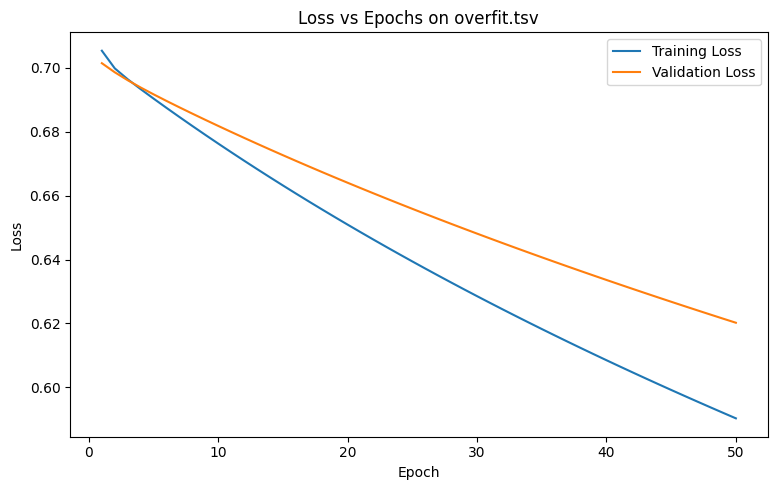

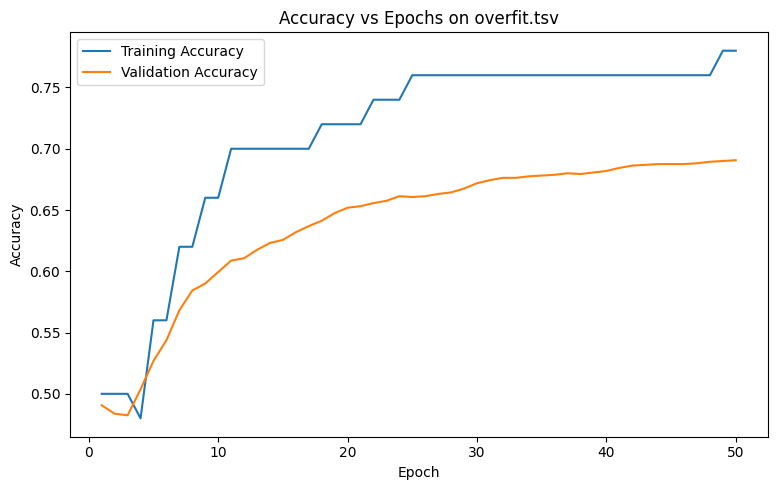

In [20]:
# Run the training loop on the baseline model:
trained_baseline_model = train_overfit(args_batch_size=4)

## 4. Obtaining the Trained Model

When training the model on the actual training data, we will slightly modify some of the above functions.

In [21]:
def plot_loss_curves(num_epochs, train_losses, val_losses):
  # Plotting
  plt.figure(figsize=(15, 5))

  # Plot training loss and test loss
  plt.subplot(1, 2, 1)
  plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
  plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss vs Epochs using train.tsv")
  plt.legend()

  plt.tight_layout()
  plt.show()

def plot_accuracy_curves(num_epochs, train_accuracies, val_accuracies):
  # Plotting
  plt.figure(figsize=(15, 5))

  # Plot training accuracy and test accuracy
  plt.subplot(1, 2, 2)
  plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
  plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs Epochs using train.tsv")
  plt.legend()

  plt.tight_layout()
  plt.show()

In [22]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(args_batch_size = 4):
  torch.manual_seed(2)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print ("Using device:", device)

  # Instantiate your model(s) and train them and so on

  # Hyperparameters:
  embedding_dim = 100 # We use embedding size = 100
  learning_rate = 0.001
  num_epochs = 50
  batch_size = args_batch_size

  # Initialize:
  model = BaselineModel(vocab=glove)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  train_dataloader, validation_dataloader, test_loader, overfit_loader = create_dataloaders(
      args_batch_size = args_batch_size, device = device
  )

  with tqdm(range(num_epochs), unit="epoch") as epochs_tqdm:
    epochs_tqdm.set_description("Training epochs:")
    for epoch in epochs_tqdm:
      model.train()

      total_loss = 0
      correct = 0
      total = 0

      for inputs, targets in train_dataloader:

        inputs = inputs.transpose(0, 1)

        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predicted = (torch.sigmoid(outputs) > 0.5).int()
        correct += (predicted.squeeze(-1) == targets).sum().item()

        total += targets.size(0)

      avg_loss = total_loss / len(train_dataloader)
      accuracy = correct / total

      train_losses.append(avg_loss)
      train_accuracies.append(accuracy)

      # Evaluate on the val set after each epoch:
      model.eval()
      total_val_loss = 0
      correct_val = 0
      total_val = 0

      with torch.no_grad():
        for inputs, targets in validation_dataloader:
            inputs = inputs.transpose(0, 1)

            outputs = model.forward(inputs)
            val_loss = criterion(outputs, targets.unsqueeze(1).float())

            total_val_loss += val_loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).int()
            correct_val += (predicted.squeeze(-1) == targets).sum().item()
            total_val += targets.size(0)

      avg_val_loss = total_val_loss / len(validation_dataloader)
      val_accuracy = correct_val / total_val

      val_losses.append(avg_val_loss)
      val_accuracies.append(val_accuracy)



  # Evaluate on the test set after training is complete:
  model.eval()
  total_test_loss = 0
  correct_test = 0
  total_test = 0

  with torch.no_grad():
      for inputs, targets in test_loader:
          inputs = inputs.transpose(0, 1)
          outputs = model.forward(inputs)
          test_loss = criterion(outputs, targets.unsqueeze(1).float())

          total_test_loss += test_loss.item()
          predicted = (torch.sigmoid(outputs) > 0.5).int()
          correct_test += (predicted.squeeze(-1) == targets).sum().item()
          total_test += targets.size(0)

  avg_test_loss = total_test_loss / len(test_loader)
  test_accuracy = correct_test / total_test

  print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

  # Plot:
  plot_loss_curves(num_epochs, train_losses, val_losses)
  plot_accuracy_curves(num_epochs, train_accuracies, val_accuracies)

  return model

Using device: cpu


Training epochs:: 100%|██████████| 50/50 [01:27<00:00,  1.74s/epoch]


Test Loss: 0.2735, Test Accuracy: 0.8975


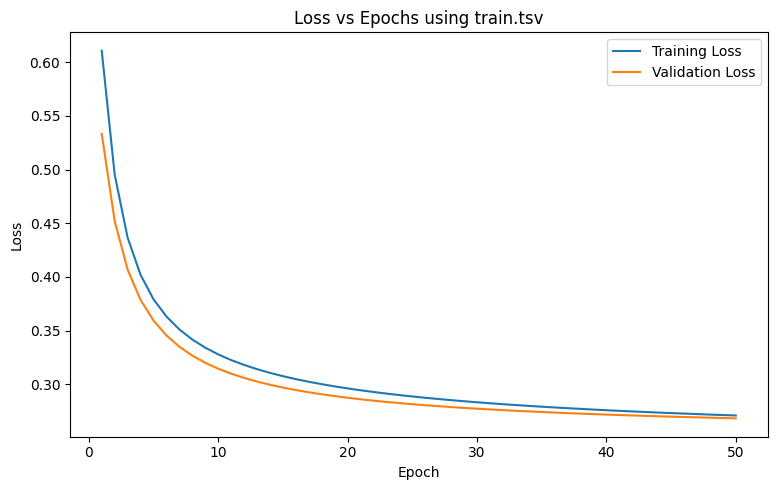

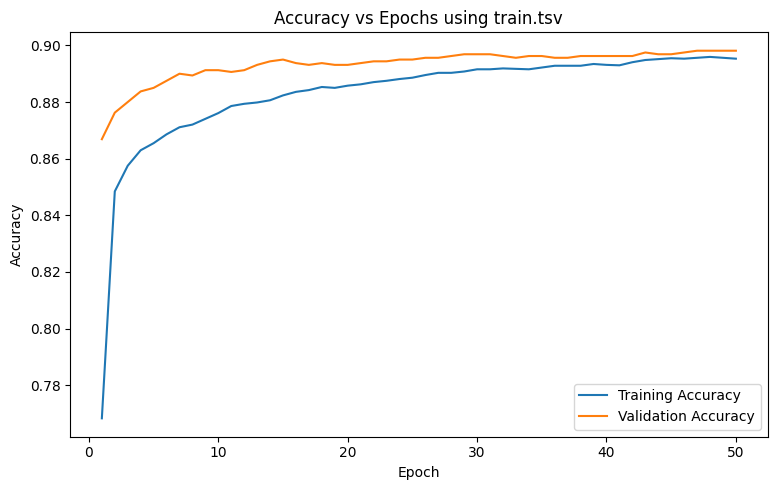

In [23]:
# Run the training loop on the baseline model:
trained_baseline_model = train(args_batch_size=4)

## 5. Interpretation of the Model Parameters 

We define a `print_closest_cosine_words()` to do this task.

In [27]:
linear_neuron_weights = trained_baseline_model.fc.weight.data
linear_neuron_weights = linear_neuron_weights.squeeze()

# Print out the N-most (where N is a parameter) similar words using cosine similarity
def print_closest_cosine_words(vec, n=5):
    # Unsqueeze to 2D tensors in order to use `torch.cosine_similarity()`:
    cos_similarities = torch.cosine_similarity(vec.unsqueeze(0), glove.vectors.unsqueeze(1), dim=2) # `dim=2` is important
    # print(cos_similarities[0:5])

    # Use enumerate() to create pairs of an index and a cosine similarity value:
    lst = sorted(enumerate(cos_similarities), key=lambda x: x[1], reverse=True) # descending order
    for idx, difference in lst[1:n+1]: # takes the top n words other than that word itself
        print(glove.itos[idx], "\t%5.2f" % difference)

print_closest_cosine_words(linear_neuron_weights, n=20)

flattering 	 0.53
underwhelming 	 0.53
campy 	 0.52
visuals 	 0.51
watchable 	 0.51
simplistic 	 0.51
emptier 	 0.50
pleasing 	 0.50
verbiage 	 0.50
uninspired 	 0.49
cartoony 	 0.49
appetizing 	 0.49
tepid 	 0.49
funnily 	 0.49
laughable 	 0.48
forgettable 	 0.48
engrossing 	 0.48
mesmerizing 	 0.48
riveting 	 0.48
cartoonish 	 0.48


## 6. Saving to a Checkpoint File

In [24]:
# 4.7: Save to .pt file:
torch.save(trained_baseline_model.state_dict(), 'model_baseline.pt')